# 11-BM (CMS) GIWAXS Plotting Notebook
**Time Series Diffraction**

Updated: 07/27/23

## Setup

### Kernel Package Installations
(Not needed if you have followed the process below under 'Environment Export')

In [1]:
### Kernel updates if needed, remember to restart kernel after running this cell!:
!pip install -e /nsls2/users/kwhite1/github_repositories/PyHyperScattering
!pip install tifftools # tifftools package for saving series image plots as tiff stacks

Obtaining file:///nsls2/users/kwhite1/github_repositories/PyHyperScattering
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for PyHyperScattering (pyproject.toml) ... done
  Created wheel for PyHyperScattering: filename=PyHyperScattering-0+untagged.539.gefb043c.dirty-0.editable-py3-none-any.whl size=5529 sha256=361de97191eb3672cc0a6e991750a4a9fb763b615c4950e859eed3018ff50206
  Stored in directory: /tmp/pip-ephem-wheel-cache-zsp0b1e0/wheels/30/84/5c/14c2ecfa0d45346e2aedbd65a4d8a149b1284612774dc76b95
Successfully built PyHyperScattering
  Attempting uninstall: PyHyperScattering
    Found existing installation: PyHyperScattering 0+untagged.524.ga38ac73.dirty
    Uninstalling PyHyperScattering-0+untagged.524.ga38ac73.dirty:
      Successfully uninstalled PyHyperScattering-0+untagged.524.ga38ac73.dirty


### Virtual Environment Setup (optional)
If you'd rather save the output NSLS-II environment as a .yml file to avoid reloading the above
packages, you can follow the procedure below:

**(0)** Capture the output of pip freeze in your notebook. 

This will give you a list of your pip-installed packages, including those installed in editable mode. 

To capture this output in your notebook in generated 'pip_requirements.txt' and 'conda_requirements.txt' files, run:

In [1]:
import envgen

envgen.main('test')


Starting process to create new environment test...
Categorizing packages...
Getting list of installed packages...
Checking package aiofiles on PyPi...
Checking package aiohttp on PyPi...
Checking package alembic on PyPi...
Checking package amostra on PyPi...
Checking package ansiwrap on PyPi...
Checking package anyio on PyPi...
Checking package appdirs on PyPi...
Checking package arabic-reshaper on PyPi...
Checking package area-detector-handlers on PyPi...
Checking package argon2-cffi on PyPi...
Checking package argon2-cffi-bindings on PyPi...
Checking package arvpyf on PyPi...
Checking package asciitree on PyPi...
Checking package asdf on PyPi...
Checking package asdf-astropy on PyPi...
Checking package asdf-coordinates-schemas on PyPi...
Checking package asdf-standard on PyPi...
Checking package asdf-transform-schemas on PyPi...
Checking package asdf-unit-schemas on PyPi...
Checking package asdf-wcs-schemas on PyPi...
Checking package asn1crypto on PyPi...
Checking package asteval on

base.yml already exists. Overwrite? (y/n):  y


Creating new environment test from base.yml...
Solving environment: ...working... failed



ResolvePackageNotFound: 
  - bluesky-base==1.11.0=pyhd8ed1ab_0
  - bluesky==1.11.0=pyha770c72_0



Installing packages into test...


sh: 1: source: not found
sh: 1: source: not found


**(1)** Export your default environment (without pip packages) into a .yml file. You'll want to exclude the prefix and the pip dependencies for now. Change the name 'pyHyper' to what you want your environment to be.

Make sure you are in the current working directory you would like the .yml to be generated, then, enter the following into the terminal:

**(bash)**
```bash
conda env export --no-builds --name base | grep -v "^prefix: " | grep -v "pip:" > base.yml


**(2.0)** Skip this step unless steps 3.0 and 3.1 work.

**(2.1.1)** Add the pip packages to your pyHyper.yml file. 
You can add the pip requirements from pip_requirements.txt to your base_environment.yml 
file manually. Open pyHyper.yml in a text editor, and add the following lines at 
the end:

```
  - pip:
    - -r file:nsls2/users/kwhite1/github_repositories/giwaxs_suite_kw/GIXSCMS/pip_requirements.txt
```

**Make sure your 'pip_requirements.txt' file is in the same directory as your pyHyper.yml file.**

**Note:** Use the absolute path of the file on the machine you are installing the environment if you have issues with finding pip_requirements.txt during the installation. You will have to change the path between your local machine installation and NSLS-II JupyterHub.

**(3.0)** Create the new environment on your local machine and the NSLS-II JupyterHub. After transferring your pyHyper.yml and pip_requirements.txt files to your local machine and the remote node, you can create the new environment (let's call it pyHyper) with:

On the NSLS-II JupyterHub, move into the folder containing **base.yml**, **pip_requirements.txt**, & **conda_requirements.txt** then run the following in the terminal:

**(bash)**
```bash
conda env create -f base.yml -n pyHyper
```

**(3.1)** Install your packages from the command line using the following syntax, first, activate your environment:

**(bash)**
```bash
conda activate pyHyper
```

Second, install the pip requirements from pip_requirements.txt:

**(bash)**
```bash
!pip install -r pip_requirements.txt
```

Third, install the conda-forge requirements from conda_requirements.txt:

**(bash)**
```bash
!while read requirement; do conda install --yes $requirement; done < conda_requirements.txt
```

**Note**: In event the installation does not proceed properly, you can remove the environment from NSLS-II JupyterHub using the following: 

**(bash)**
```bash
conda env remove --name pyHyper

```

This will create a new Conda environment named myenv with the same packages as your default environment.

**(4)** Install new packages in editable mode. Navigate to your package directory using **ls** and **cd** and run the pip installations. Analogous to the **Kernel Package Installations** step above, you can run the following in the terminal:

**(bash)**
```bash
# pip install -e # this is the generalized form
pip install -e /nsls2/users/kwhite1/github_repositories/PyHyperScattering
pip install tifftools # tifftools package for saving series image plots as tiff stacks
```

**(5)** After installation, and for each session moving forward, make sure to activate your new environment using:

**(bash)**
```bash
conda activate pyHyper
```

## Module Imports

In [2]:
import pathlib, re, os, gc
import tifftools  # only needed if loading tiffs, requires installing into default ipykernel: !pip install tifftools
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import PyHyperScattering as phs
from tqdm.auto import tqdm  # progress bar loader!

# Define colormap:
cmap = plt.cm.turbo
cmap.set_bad('black')

# Print current PyHyperScattering Version
print(f'Using PyHyperScattering Version: {phs.__version__}')

/nsls2/users/kwhite1/github_repositories/PyHyperScattering/src/PyHyperScattering/integrate.py:3: UserWarning: Could not import CuPy or ndigpu.  If you expect this machine to support CuPy, check dependencies.  Falling back to scikit-image/numpy CPU integration.
  from PyHyperScattering.WPIntegrator import WPIntegrator


Using PyHyperScattering Version: 0+untagged.539.gefb043c.dirty


## Defining Paths, Data Reduction Objects, & Sample Specific Information

In [3]:
# Define your relevant paths here, you can use the ".exists()" method to make sure you defined a path correctly.
userPath = pathlib.Path('/nsls2/users/kwhite1')  # Your users path is great for small items that are personal to you (100 GB limit)
propPath = pathlib.Path('/nsls2/data/cms/proposals/2023-2/pass-311415')  # The proposals path is a good place to store large data (>1 TB space?)
dataPath = propPath.joinpath('2023C2_KWhite')
maskponiPath = userPath.joinpath('github_repositories/giwaxs_suite/ponimask_kwhite')
savePath = dataPath.joinpath('analysis')

# PONI File & Mask Filepaths
poniFile = maskponiPath.joinpath('jun23_poni_01_LaB6_5.6m_12.7keV_corrected_1150.1s_x-1.601_th0.500_5.00s_1116949_maxs.poni')
maskFile = maskponiPath.joinpath('jun23_nslsii11bmcms_WAXS2pil1M_mask_02.edf')

# Zarr Series File Paths
raw_seriesPath = savePath.joinpath('raw_series_zarrs')
recip_seriesPath = savePath.joinpath('recip_series_zarrs')
caked_seriesPath = savePath.joinpath('caked_series_zarrs')

tiffPath = savePath.joinpath('tiff_stacks')
# -------------------------
# Originating Data Folders
# /nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite
# /nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite2
# /nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite3
# /nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite4
# /nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite5

# Proposal (Data) Folders
# /nsls2/data/cms/proposals/2023-2/pass-311415/
# /nsls2/data/cms/proposals/2023-2/pass-311415/2023C1_KWhite/
# /nsls2/data/cms/proposals/2023-2/pass-311415/2023C2_KWhite/
# /nsls2/data/cms/proposals/2023-1/pass-310206/

# Analysis Folders
# /nsls2/data/cms/proposals/2023-2/pass-311415/2023C2_KWhite/analysis/

# Repos
# /nsls2/users/kwhite1/github_repositories
# /nsls2/users/kwhite1/github_repositories/PyHyperScattering

#### Universal Function Definitions

In [4]:
def sort_by_suffix(filename):
    match = re.search(r'_(\d+)\.zarr$', filename)
    if match:
        return int(match.group(1))
    return 0

In [5]:
# List the files inside a folder
sorted([f.name for f in savePath.iterdir()])  # a simple way to list just the filenames and not the whole path

['.ipynb_checkpoints',
 'caked_series_zarrs',
 'raw_series_zarrs',
 'recip_series_zarrs',
 'tiff_stacks']

# GIWAXS Plotting

### Data Loading (ZARR)

#### Load raw ZARR Dataset

In [42]:
# def sort_by_suffix(filename):
#     match = re.search(r'_(\d+)\.zarr$', filename)
#     if match:
#         return int(match.group(1))
#     return 0

raw_filelist = sorted([f.name for f in raw_seriesPath.iterdir()])  # a simple way to list just the filenames and not the whole path
raw_filelist = sorted(raw_filelist, key=sort_by_suffix)

for index, file in enumerate(raw_filelist):
    print(f'[{index}] {file}', end='\n')

[0] raw_sam0_pbi2_dmf_0p5m_1115972_001.zarr
[1] raw_sam1_pbi2_dmf_0p3m_1116002_002.zarr
[2] raw_sam4_pbi2_dmf_0p3m_1116020_003.zarr
[3] raw_sam3_pbi2_dmf_0p1m_1116043_004.zarr
[4] raw_sam2_pbi2_dmf_0p05m_1116080_005.zarr
[5] raw_sam9_pbi2_dmso_0p5m_1116099_006.zarr
[6] raw_sam6_pbi2_dmso_0p05m_1116124_007.zarr
[7] raw_sam10_1mai1pbi2_dmf_0p01m_1116172_008.zarr
[8] raw_sam13_3mai1pbi2_dmf_0p01m_1116202_009.zarr
[9] raw_sam16_3mai1pbi2_dmf_1m_1116215_010.zarr
[10] raw_sam99_1mai1pbi2_1dmf1dmso_1m_1116248_011.zarr
[11] raw_sam98_3mai1pbi2_1dmf1dmso_1m_1116263_012.zarr
[12] raw_sam22_1mai1pbi2_dmso_1m_1116294_013.zarr
[13] raw_sam26_3mai1pbi2_dmso_1m_1116316_014.zarr
[14] raw_sam29_1mai1pbi2_dmf_0p1m_1116337_015.zarr
[15] raw_sam30_1mai1pbi2_dmf_0p5m_1116356_016.zarr
[16] raw_sam31_3mai1pbi2_dmf_0p1m_1116378_017.zarr
[17] raw_sam32_3mai1pbi2_dmf_0p5m_1116405_018.zarr


In [43]:
raw_selection = 17 # selection value corresponding to list above
raw_filename = raw_filelist[raw_selection]
print(raw_filename)

raw_DA = xr.open_zarr(raw_seriesPath.joinpath(raw_filename)).DA
raw_DA # display the DataArray

raw_sam32_3mai1pbi2_dmf_0p5m_1116405_018.zarr


<xarray.DataArray 'DA' (time: 3622, pix_y: 1043, pix_x: 981)>
dask.array<open_dataset-DA, shape=(3622, 1043, 981), dtype=int32, chunksize=(227, 66, 62), chunktype=numpy.ndarray>
Coordinates:
  * pix_x          (pix_x) int64 0 1 2 3 4 5 6 7 ... 974 975 976 977 978 979 980
  * pix_y          (pix_y) int64 0 1 2 3 4 5 6 ... 1037 1038 1039 1040 1041 1042
    series_number  (time) int64 dask.array<chunksize=(3622,), meta=np.ndarray>
  * time           (time) float64 0.5 1.0 1.5 ... 1.81e+03 1.81e+03 1.811e+03
Attributes: (12/14)
    chemistry:        3mai1pbi2
    concentration:    0p5m
    detector:         maxs.tiff
    exposure_time:    0.49s
    flow_rate:        5scfh
    incident_angle:   th0.300
    ...               ...
    scan_id:          1116405
    solution_volume:  40uL
    solvent:          dmf
    substrate:        Si
    time_start:       2563.4s
    x_pos:            x-0.001

In [8]:
raw_DA # display the DataArray

<xarray.DataArray 'DA' (time: 2422, pix_y: 1043, pix_x: 981)>
dask.array<open_dataset-DA, shape=(2422, 1043, 981), dtype=int32, chunksize=(152, 66, 123), chunktype=numpy.ndarray>
Coordinates:
  * pix_x          (pix_x) int64 0 1 2 3 4 5 6 7 ... 974 975 976 977 978 979 980
  * pix_y          (pix_y) int64 0 1 2 3 4 5 6 ... 1037 1038 1039 1040 1041 1042
    series_number  (time) int64 dask.array<chunksize=(2422,), meta=np.ndarray>
  * time           (time) float64 0.5 1.0 1.5 ... 1.21e+03 1.21e+03 1.211e+03
Attributes: (12/14)
    chemistry:        1mai1pbi2
    concentration:    0p1m
    detector:         maxs.tiff
    exposure_time:    0.49s
    flow_rate:        5scfh
    incident_angle:   th0.300
    ...               ...
    scan_id:          1116337
    solution_volume:  40uL
    solvent:          dmf
    substrate:        Si
    time_start:       1879.9s
    x_pos:            x-0.001

#### Load Reciprocal Space ZARR Dataset

In [18]:
recip_filelist = sorted([f.name for f in recip_seriesPath.iterdir()])  # a simple way to list just the filenames and not the whole path
recip_filelist = sorted(recip_filelist, key=sort_by_suffix)

for index, file in enumerate(recip_filelist):
    print(f'[{index}] {file}', end='\n')

[0] recip_sam0_pbi2_dmf_0p5m_1115972_001.zarr
[1] recip_sam1_pbi2_dmf_0p3m_1116002_002.zarr
[2] recip_sam4_pbi2_dmf_0p3m_1116020_003.zarr
[3] recip_sam3_pbi2_dmf_0p1m_1116043_004.zarr
[4] recip_sam2_pbi2_dmf_0p05m_1116080_005.zarr
[5] recip_sam6_pbi2_dmso_0p05m_1116124_007.zarr
[6] recip_sam10_1mai1pbi2_dmf_0p01m_1116172_008.zarr
[7] recip_sam13_3mai1pbi2_dmf_0p01m_1116202_009.zarr
[8] recip_sam16_3mai1pbi2_dmf_1m_1116215_010.zarr
[9] recip_sam99_1mai1pbi2_1dmf1dmso_1m_1116248_011.zarr
[10] recip_sam22_1mai1pbi2_dmso_1m_1116294_013.zarr
[11] recip_sam29_1mai1pbi2_dmf_0p1m_1116337_015.zarr
[12] recip_sam30_1mai1pbi2_dmf_0p5m_1116356_016.zarr
[13] recip_sam32_3mai1pbi2_dmf_0p5m_1116405_018.zarr


In [41]:
recip_selection = 12 # selection value corresponding to list above
recip_filename = recip_filelist[recip_selection]
# print(raw_filename)

recip_DA = xr.open_zarr(recip_seriesPath.joinpath(recip_filename)).DA

recip_DA # display the DataArray

<xarray.DataArray 'DA' (time: 2422, q_z: 1043, q_xy: 981)>
dask.array<open_dataset-DA, shape=(2422, 1043, 981), dtype=float32, chunksize=(152, 66, 123), chunktype=numpy.ndarray>
Coordinates:
  * q_xy     (q_xy) float64 -2.563 -2.558 -2.554 -2.549 ... 1.843 1.848 1.852
  * q_z      (q_z) float64 0.03993 0.04257 0.04521 0.04785 ... 2.783 2.786 2.788
  * time     (time) float64 0.5 1.0 1.5 2.0 ... 1.21e+03 1.21e+03 1.211e+03
Attributes: (12/14)
    chemistry:        1mai1pbi2
    concentration:    0p5m
    detector:         maxs.tiff
    exposure_time:    0.49s
    flow_rate:        5scfh
    incident_angle:   th0.300
    ...               ...
    scan_id:          1116356
    solution_volume:  40uL
    solvent:          dmf
    substrate:        Si
    time_start:       1815.7s
    x_pos:            x-0.001

In [ ]:
recip_DA # display the DataArray

#### Load Caked ZARR Dataset

In [ ]:
caked_filelist = sorted([f.name for f in caked_seriesPath.iterdir()])  # a simple way to list just the filenames and not the whole path
caked_filelist = sorted(caked_filelist, key=sort_by_suffix)

for index, file in enumerate(caked_filelist):
    print(f'[{index}] {file}', end='\n')

In [ ]:
caked_selection = 5 # selection value corresponding to list above
caked_filename = caked_filelist[caked_selection]
print(caked_filename)

caked_DA = xr.open_zarr(caked_seriesPath.joinpath(caked_filename)).DA

### 2D Image Plotting

#### Setup Plotting Color Map, Intensity Limits, Shaping

In [44]:
cmap = plt.cm.turbo.copy()
cmap.set_bad('black')
clim = (5, 1e3)

# np.ravel(axs.axs).shape 

#### Plotting Different Types of 2D Images
Make sure your slice dimensions correspond to the values assigned in the xarray (DataArray). There are differences in the raw, recip, and caked xarray (DataArrays).

#### Plot RAW 2D Data (Grid)

In [45]:
# List RAW Files
raw_filelist = sorted([f.name for f in raw_seriesPath.iterdir()])  # a simple way to list just the filenames and not the whole path
raw_filelist = sorted(raw_filelist, key=sort_by_suffix)

for index, file in enumerate(raw_filelist):
    print(f'[{index}] {file}', end='\n')

[0] raw_sam0_pbi2_dmf_0p5m_1115972_001.zarr
[1] raw_sam1_pbi2_dmf_0p3m_1116002_002.zarr
[2] raw_sam4_pbi2_dmf_0p3m_1116020_003.zarr
[3] raw_sam3_pbi2_dmf_0p1m_1116043_004.zarr
[4] raw_sam2_pbi2_dmf_0p05m_1116080_005.zarr
[5] raw_sam9_pbi2_dmso_0p5m_1116099_006.zarr
[6] raw_sam6_pbi2_dmso_0p05m_1116124_007.zarr
[7] raw_sam10_1mai1pbi2_dmf_0p01m_1116172_008.zarr
[8] raw_sam13_3mai1pbi2_dmf_0p01m_1116202_009.zarr
[9] raw_sam16_3mai1pbi2_dmf_1m_1116215_010.zarr
[10] raw_sam99_1mai1pbi2_1dmf1dmso_1m_1116248_011.zarr
[11] raw_sam98_3mai1pbi2_1dmf1dmso_1m_1116263_012.zarr
[12] raw_sam22_1mai1pbi2_dmso_1m_1116294_013.zarr
[13] raw_sam26_3mai1pbi2_dmso_1m_1116316_014.zarr
[14] raw_sam29_1mai1pbi2_dmf_0p1m_1116337_015.zarr
[15] raw_sam30_1mai1pbi2_dmf_0p5m_1116356_016.zarr
[16] raw_sam31_3mai1pbi2_dmf_0p1m_1116378_017.zarr
[17] raw_sam32_3mai1pbi2_dmf_0p5m_1116405_018.zarr


In [68]:
# Select your RAW File
raw_selection = 1 # selection value corresponding to list above
raw_filename = raw_filelist[raw_selection]
print(raw_filename)

raw_DA = xr.open_zarr(raw_seriesPath.joinpath(raw_filename)).DA

raw_DA

raw_sam1_pbi2_dmf_0p3m_1116002_002.zarr


<xarray.DataArray 'DA' (time: 2420, pix_y: 1043, pix_x: 981)>
dask.array<open_dataset-DA, shape=(2420, 1043, 981), dtype=int32, chunksize=(152, 66, 123), chunktype=numpy.ndarray>
Coordinates:
  * pix_x          (pix_x) int64 0 1 2 3 4 5 6 7 ... 974 975 976 977 978 979 980
  * pix_y          (pix_y) int64 0 1 2 3 4 5 6 ... 1037 1038 1039 1040 1041 1042
    series_number  (time) int64 dask.array<chunksize=(2420,), meta=np.ndarray>
  * time           (time) float64 0.5 1.0 1.5 ... 1.209e+03 1.21e+03 1.21e+03
Attributes: (12/14)
    chemistry:        pbi2
    concentration:    0p3m
    detector:         maxs.tiff
    exposure_time:    0.49s
    flow_rate:        5scfh
    incident_angle:   th0.300
    ...               ...
    scan_id:          1116002
    solution_volume:  40uL
    solvent:          dmf
    substrate:        Si
    time_start:       2067.3s
    x_pos:            x2.002

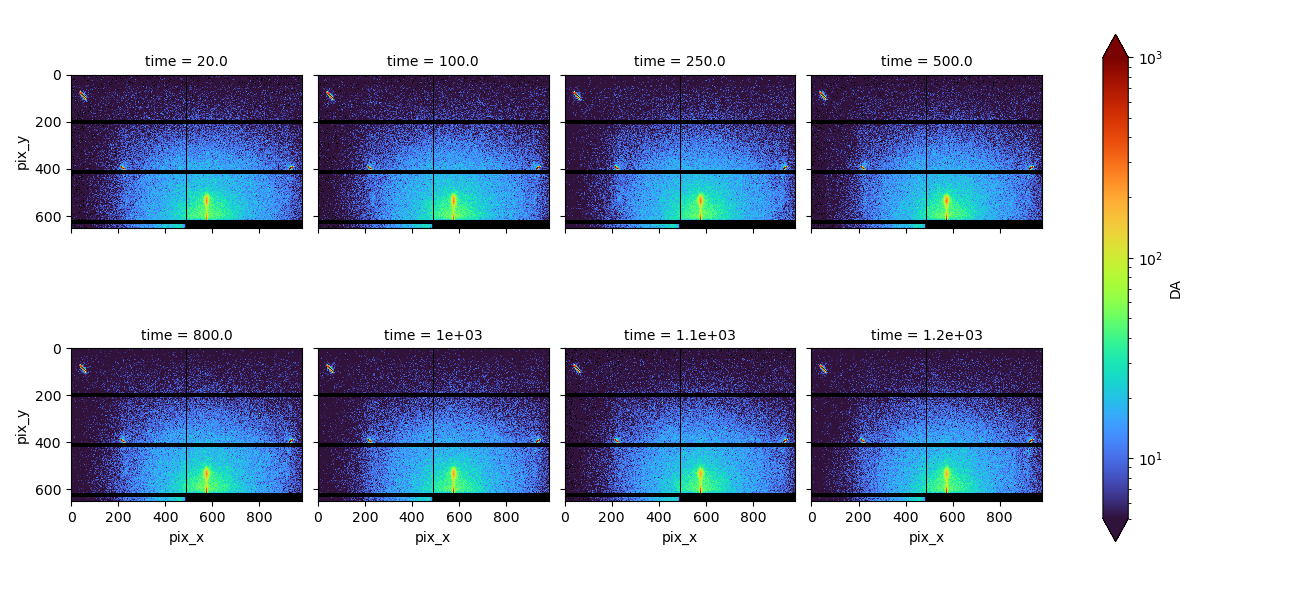

In [69]:
%matplotlib widget
# Plot a grid of RAW Files

# Define the color map
cmap = plt.cm.turbo.copy()
cmap.set_bad('black')
clim = (5, 1e3)
# clim = (5, 5e2)

# Define the axes
# axs = raw_DA.sel(time=[20, 100, 250, 500, 750, 1000, 1250, 1500], # 0.1 M
# axs = raw_DA.sel(time=[20, 100, 250, 500, 800, 1000, 1100, 1200], # 0.3 M
# axs = raw_DA.sel(time=[20, 100, 250, 500, 800, 1000, 1100, 1200], # 0.5 M
# axs = raw_DA.sel(time=[20, 100, 250, 500, 750, 1000, 1500, 1800], # 0.05 M
# axs = raw_DA.sel(time=[20, 100, 250, 500, 800, 1000, 1100, 1200], # 0.01 M
                 method='nearest').sel(pix_y=slice(0, 650)).plot.imshow(col='time', 
                                                                        col_wrap=4, 
                                                                        origin='upper', 
                                                                        cmap=cmap, 
                                                                        norm=LogNorm(clim[0], clim[1]))

# note that raw data is plotted with origin = 'upper', and reciprocal space maps are plotted with origin = 'lower'
for axes in np.ravel(axs.axs):
    axes.set(aspect='equal')

#### Plot Reciprocal Space Map 2D Data (Single Image)

In [ ]:
# List RECIP Files
recip_filelist = sorted([f.name for f in recip_seriesPath.iterdir()])  # a simple way to list just the filenames and not the whole path
recip_filelist = sorted(recip_filelist, key=sort_by_suffix)

for index, file in enumerate(recip_filelist):
    print(f'[{index}] {file}', end='\n')

[0] recip_sam0_pbi2_dmf_0p5m_1115972_001.zarr
[1] recip_sam1_pbi2_dmf_0p3m_1116002_002.zarr
[2] recip_sam4_pbi2_dmf_0p3m_1116020_003.zarr
[3] recip_sam3_pbi2_dmf_0p1m_1116043_004.zarr
[4] recip_sam2_pbi2_dmf_0p05m_1116080_005.zarr
[5] recip_sam9_pbi2_dmso_0p5m_1116099_006.zarr
[6] recip_sam6_pbi2_dmso_0p05m_1116124_007.zarr
[7] recip_sam10_1mai1pbi2_dmf_0p01m_1116172_008.zarr
[8] recip_sam13_3mai1pbi2_dmf_0p01m_1116202_009.zarr
[9] recip_sam16_3mai1pbi2_dmf_1m_1116215_010.zarr
[10] recip_sam99_1mai1pbi2_1dmf1dmso_1m_1116248_011.zarr
[11] recip_sam98_3mai1pbi2_1dmf1dmso_1m_1116263_012.zarr
[12] recip_sam22_1mai1pbi2_dmso_1m_1116294_013.zarr
[13] recip_sam26_3mai1pbi2_dmso_1m_1116316_014.zarr
[14] recip_sam29_1mai1pbi2_dmf_0p1m_1116337_015.zarr
[15] recip_sam30_1mai1pbi2_dmf_0p5m_1116356_016.zarr
[16] recip_sam31_3mai1pbi2_dmf_0p1m_1116378_017.zarr
[17] recip_sam32_3mai1pbi2_dmf_0p5m_1116405_018.zarr


In [ ]:
# Select your RECIP File
recip_selection = 11 # selection value corresponding to list above
recip_filename = recip_filelist[recip_selection]
print(recip_filename)

recip_DA = xr.open_zarr(recip_seriesPath.joinpath(recip_filename)).DA

recip_sam4_pbi2_dmf_0p3m_1116020_003.zarr


In [ ]:
# Check your RECIP File
recip_DA

<xarray.DataArray 'DA' (time: 2420, q_z: 1043, q_xy: 981)>
dask.array<open_dataset-DA, shape=(2420, 1043, 981), dtype=float32, chunksize=(152, 66, 123), chunktype=numpy.ndarray>
Coordinates:
  * q_xy     (q_xy) float64 -2.563 -2.558 -2.554 -2.549 ... 1.843 1.848 1.852
  * q_z      (q_z) float64 0.03993 0.04257 0.04521 0.04785 ... 2.783 2.786 2.788
  * time     (time) float64 0.5 1.0 1.5 2.0 ... 1.209e+03 1.21e+03 1.21e+03
Attributes: (12/14)
    chemistry:        pbi2
    concentration:    0p3m
    detector:         maxs.tiff
    exposure_time:    0.49s
    flow_rate:        5scfh
    incident_angle:   th0.300
    ...               ...
    scan_id:          1116020
    solution_volume:  40uL
    solvent:          dmf
    substrate:        Si
    time_start:       2934.5s
    x_pos:            x2.002

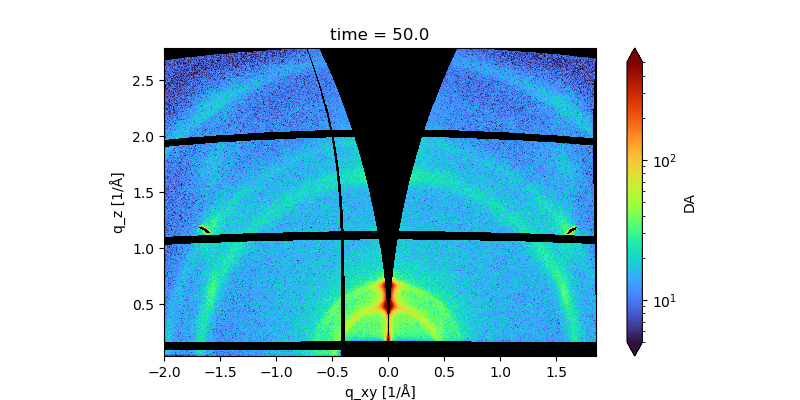

In [80]:
%matplotlib widget

# Plot your RECIP Data Frame
cmap = plt.cm.turbo.copy()
cmap.set_bad('black')
clim = (5, 5e2)

# Define the axes
# axs = raw_DA.sel(time=[20, 100, 250, 500, 750, 1000, 1250, 1500], # 0.1 M
# axs = raw_DA.sel(time=[20, 100, 250, 500, 800, 1000, 1100, 1200], # 0.3 M
# axs = raw_DA.sel(time=[20, 100, 250, 500, 800, 1000, 1100, 1200], # 0.5 M
# axs = raw_DA.sel(time=[20, 100, 250, 500, 750, 1000, 1500, 1800], # 0.05 M
# axs = raw_DA.sel(time=[20, 100, 250, 500, 800, 1000, 1100, 1200], # 0.01 M


# Define the axes
# axs = raw_DA.sel(time=[20, 100, 250, 500, 750, 1000, 1250, 1500], # 0.1 M
# axs = raw_DA.sel(time=[20, 100, 250, 500, 800, 1000, 1100, 1200], # 0.3 M
# axs = raw_DA.sel(time=[20, 100, 250, 500, 800, 1000, 1100, 1200], # 0.5 M
# axs = raw_DA.sel(time=[20, 100, 250, 500, 750, 1000, 1500, 1800], # 0.05 M
# axs = raw_DA.sel(time=[20, 100, 250, 500, 800, 1000, 1100, 1200], # 0.01 M
                 # method='nearest').sel(pix_y=slice(0, 650)).plot.imshow(col='time', 
                 #                                                        col_wrap=4, 
                 #                                                        origin='upper', 
                 #                                                        cmap=cmap, 
                 #                                                        norm=LogNorm(clim[0], clim[1]))
                    
ax = recip_DA.sel(time=50, method='nearest').sel(q_z=slice(-0.01, 3), 
                                           q_xy=slice(-2, 2)).plot.imshow(cmap=cmap, 
                                                                          norm=LogNorm(clim[0], clim[1]), 
                                                                          figsize=(8,4))
ax.axes.set(aspect='equal')
plt.show()

#### Plot Reciprocal Space Map 2D Data (Grid)

In [ ]:
axs = recip_DA.sel(time=[100, 200, 300, 400, 500, 600, 700, 1000], 
                   method='nearest').sel(q_z=slice(0, 2.5)).plot.imshow(col='time', 
                                                                        col_wrap=4, 
                                                                        origin='lower', 
                                                                        cmap=cmap, 
                                                                        norm=LogNorm(clim[0], 
                                                                                     clim[1]))
for axes in np.ravel(axs.axs):
    axes.set(aspect='equal')

#### Plot Reciprocal Space Map 2D Data (Grid) 'Fancy'

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker

%matplotlib widget

# Create a color map
cmap = plt.cm.turbo.copy()
cmap.set_bad('black')
clim = (5, 1e3)

title = f'{recip_DA.chemistry}_{recip_DA.solvent}_{recip_DA.concentration}' #{recip_DA.samplenum}_{recip_DA.scan_id}_{recip_DA.run_number}'

# Plot the selected data
axs = recip_DA.sel(time=[100, 200, 300, 400, 500, 600, 700, 1000], 
                   method='nearest').sel(q_z=slice(0, 2.5)).plot.imshow(col='time', 
                                                                        col_wrap=4, 
                                                                        origin='lower', 
                                                                        cmap=cmap, 
                                                                        norm=LogNorm(clim[0], 
                                                                                     clim[1]))
# plt.subplots_adjust(hspace= -0.05) # Adjust space between rows of images

# Set aspect ratio, x-axis labels, and additional tick marks
for i, ax in enumerate(np.ravel(axs.axes)):
    ax.set_aspect('equal') # Keeps the pixels square
    ax.set_xlabel('$q_{xy}$  (Å$^{-1}$)', fontsize=12) # Add custom x-axis labels to all images
    
    if i%4 == 0: # First column
        ax.set_ylabel('$q_{z}$  (Å$^{-1}$)', fontsize=12) # Add custom y-axis labels to all images
    else:
        ax.set_ylabel('') # No label
    
    ax.xaxis.set_major_locator(ticker.MaxNLocator(5)) # Add 5 ticks on x-axis
    ax.yaxis.set_major_locator(ticker.MaxNLocator(5)) # Add 5 ticks on y-axis
    ax.xaxis.set_minor_locator(ticker.NullLocator()) # Remove minor x tick labels
    ax.yaxis.set_minor_locator(ticker.NullLocator()) # Remove minor y tick labels

plt.suptitle(title, fontsize=16, y=1) # Add title to the figure

#### Plot Caked 2D Images (Single)

In [ ]:
# List CAKED Datasets
caked_filelist = sorted([f.name for f in caked_seriesPath.iterdir()])  # a simple way to list just the filenames and not the whole path
caked_filelist = sorted(caked_filelist, key=sort_by_suffix)

for index, file in enumerate(caked_filelist):
    print(f'[{index}] {file}', end='\n')

In [ ]:
# Select CAKED Dataset
caked_selection = 5 # selection value corresponding to list above
caked_filename = caked_filelist[caked_selection]
print(caked_filename)

caked_DA = xr.open_zarr(caked_seriesPath.joinpath(caked_filename)).DA

In [ ]:
# Check CAKED Dataset
caked_DA # display the DataArray

In [ ]:
%matplotlib

# Plot the CAKED Dataset

caked_DA.sel(time=90,  # select the timestamp
             method='nearest').sel(chi=slice(-90, 90), # select the chi slice
                                            qr=slice(0,2)).plot.imshow(cmap=cmap, # select the qr slice
                                                                         norm=LogNorm(4, 2e2), 
                                                                         interpolation='antialiased')

#### Applying sin(chi) Correction
Example of how to plot with sin(chi) correction using xarray

In [ ]:

# Create the correction mask.
sin_chi_DA = np.sin(np.radians(np.abs(caked_DA.chi)))
# sin_chi_DA

# Apply the correction.
corr_DA = caked_DA * sin_chi_DA
# corr_DA

# Plot the original data.
fig, axs = plt.subplots(1,2)
caked_DA.sel(time=60, method='nearest').sel(chi=slice(-90,60), 
                                      qr=slice(0,2)).plot.imshow(ax=axs[0], 
                                                                 cmap=cmap, 
                                                                 norm=LogNorm(0.8, 4e1))
# Plot the corrected data.
corr_DA.sel(time=60, method='nearest').sel(chi=slice(-90,60), 
                                           qr=slice(0,2)).plot.imshow(ax=axs[1], 
                                                                      cmap=cmap, 
                                                                      norm=LogNorm(0.8, 4e1))

fig.set(tight_layout=True, size_inches=(10,5))
plt.show()

### Plot tr-GIWAXS Series

#### Load the DataArray

In [ ]:
# List the CAKED Datasets
caked_filelist = sorted([f.name for f in caked_seriesPath.iterdir()])  # a simple way to list just the filenames and not the whole path
caked_filelist = sorted(caked_filelist, key=sort_by_suffix)

for index, file in enumerate(caked_filelist):
    print(f'[{index}] {file}', end='\n')

In [ ]:
# Select a CAKED Dataset
caked_selection = 3 # selection value corresponding to list above
caked_filename = caked_filelist[caked_selection]
print(caked_filename)

caked_DA = xr.open_zarr(caked_seriesPath.joinpath(caked_filename)).DA

In [ ]:
# Check the CAKED Dataset
caked_DA

#### Plot tr-GIWAXS w/ sin(chi) Correction

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker
import numpy as np

# Create a color map
cmap = plt.cm.turbo.copy()
cmap.set_bad('black')
clim = (8e2, 3e3)  # sin(chi)
# clim = (8e2, 2e4)

sin_chi_DA = np.sin(np.radians(np.abs(caked_DA.chi)))
# sin_chi_DA

corr_DA = caked_DA * sin_chi_DA
# corr_DA = caked_DA

# Create the plot
im = corr_DA.sel(qr=slice(0,2.5)).sum(dim='chi').plot.imshow(x='time', 
                                        y='qr', 
                                        cmap=cmap, 
                                        norm=LogNorm(clim[0], clim[1]), 
                                        interpolation='antialiased')

# Add the custom axes labels and title
# xlabel='$q_{xy}$ $[Å^{-1}]$'
xlabel='time $(s)$'
plt.xlabel(xlabel)

# ylabel='time $q_{z}$ $[Å^{-1}]$'
ylabel='$q_{r}$ $[Å^{-1}]$'
plt.ylabel(ylabel)

# title = f'{caked_DA.samplenum}_{caked_DA.chemistry}_{caked_DA.solvent}_{caked_DA.concentration}_{caked_DA.scan_id}_{caked_DA.run_number}'
title = f'{caked_DA.chemistry} - {caked_DA.solvent}, {caked_DA.concentration}'
plt.title(title)

# Show the plot
plt.show()

#### Generate tr-GIWAXS TIFF Montage

In [ ]:
!pip install tifftools # Install tifftools if you haven't already

print('Make sure the restart the kernel!')

In [ ]:
# Check your savePath
savePath

In [ ]:
# Define the tiffPath if you haven't already.
tiffPath = savePath.joinpath('tiff_stacks')

if not os.path.exists(tiffPath): # if this path doesn't exist create it
    os.makedirs(tiffPath) # Make the new directory for the batch process save folder.

tiffPath

#### Create TIFF Stacks Iteratively (Multiple Samples)

In [ ]:
recip_filelist = sorted([f.name for f in recip_seriesPath.iterdir()])  # a simple way to list just the filenames and not the whole path
recip_filelist = sorted(recip_filelist, key=sort_by_suffix)

for index, file in enumerate(recip_filelist):
    print(f'[{index}] {file}', end='\n')

In [ ]:
cmap = plt.cm.turbo
cmap.set_bad('black')
clim = (5, 1e3)

# Loop through all of your RECIP .zarr Files
for i, recip_filename in enumerate(recip_filelist):
    
    recip_DA = xr.open_zarr(recip_seriesPath.joinpath(recip_filename)).DA
    print (recip_filename)
    
    samplename = f'{recip_DA.samplenum}_{recip_DA.chemistry}_{recip_DA.solvent}_{recip_DA.concentration}_{recip_DA.scan_id}_{recip_DA.run_number}'
    samplepath = samplename + '/'
    print(samplename)
    
    sampletiffPath = os.path.join(tiffPath, samplepath) # Merge the new time stamped folder name with the existing data_folder path

    if not os.path.exists(sampletiffPath): # if this path doesn't exist create it
        os.makedirs(sampletiffPath) # Make the new directory for the batch process save folder.

    for time in recip_DA.time:
        time = np.round(float(time), 1)
        ax = recip_DA.sel(time=time, 
                          method='nearest').sel(q_z=slice(-0.01,2), 
                                                q_xy=slice(-2,2)).plot.imshow(cmap=cmap, 
                                                                              # norm=LogNorm(vlim[0], vlim[1]), 
                                                                              norm=LogNorm(clim[0], clim[1]),
                                                                              figsize=(10,4), 
                                                                              interpolation='antialiased')
        
        title = f'{recip_DA.chemistry}_{recip_DA.solvent}_{recip_DA.concentration}' + f'; Time = {time} s'
        ax.axes.set(aspect='equal', 
                    xlabel='$q_{xy}$ $[Å^{-1}]$', 
                    ylabel='$q_{z}$ $[Å^{-1}]$', 
                    title = title)
                    # title=f'PbI2 DMF, 0.3 M; Time = {time} s')

        # samplename = f'{recip_DA.samplenum}_{recip_DA.chemistry}_{recip_DA.solvent}_{recip_DA.concentration}_{recip_DA.scan_id}_{recip_DA.run_number}'
        # plt.show()

        ax.figure.set_tight_layout(True)
        ax.figure.savefig(savePath.joinpath(f'tiff_stacks/' + samplename + '/' + samplename + f'_time-{time}.tiff'), dpi=120)
        plt.close('all')

    ### Stack tiff frames
    framePaths = sorted(savePath.joinpath(f'tiff_stacks/' + samplename + '/').glob(f'{samplename}*'), 
                        key=lambda x: float(str(x).split('-')[-1][:-5]))

    frame1 = tifftools.read_tiff(framePaths[0])

    for framePath in framePaths[1:]:
        frame = tifftools.read_tiff(framePath)
        frame1['ifds'].extend(frame['ifds'])

    tifftools.write_tiff(frame1, savePath.joinpath(f'tiff_stacks/' + samplename + f'/recip_{samplename}.tiff'), allowExisting=True)
    
    # Clean up your memory between iterations.
    del recip_DA
    del frame1
    gc.collect()

#### Create MOV Files from TIFF Image Stacks

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
from pathlib import Path
import numpy as np

def tiff_to_mov(tiff_path, frame_rate=24):
    # Use PIL's Image module to open the tiff file
    tiff_stack = Image.open(tiff_path)
    
    # Convert each tiff image in the stack to a numpy array
    images = []
    for i in range(tiff_stack.n_frames):
        tiff_stack.seek(i)
        images.append(np.array(tiff_stack))
    
    # Create a figure for the animation
    fig = plt.figure()
    
    # Display the first image in the stack
    img = plt.imshow(images[0], animated=True)
    plt.axis('off')  # Turn off the axis
    
    def update_img(n):
        # Update the image for the nth frame
        img.set_array(images[n])
        return img,
    
    # Create the animation
    ani = animation.FuncAnimation(fig, update_img, frames=range(len(images)), interval=1000/frame_rate, blit=True)
    
    # Save the animation
    output_path = Path(tiff_path).with_suffix('.mov')
    ani.save(output_path, writer='ffmpeg', fps=frame_rate)
    
    return str(output_path)

tiffPath = '/nsls2/data/cms/proposals/2023-2/pass-311415/2023C2_KWhite/analysis/tiff_stacks/sam0_pbi2_dmf_0p5m_1115972_001/recip_sam0_pbi2_dmf_0p5m_1115972_001.tiff'
movPath = tiff_to_mov(tiffPath, frame_rate=60)
print(f"Animation saved at: {movPath}")

#### Play the MOV File

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def play_mov(file_path):
    # Open the video file and convert it to base64
    video_data = open(file_path, "rb").read()
    video_encoded = b64encode(video_data).decode("ascii")
    
    # Create an HTML string that includes the base64-encoded video data
    video_tag = f'<video controls src="data:video/mp4;base64,{video_encoded}" />'
    
    # Display the video
    return HTML(data=video_tag)

In [ ]:
# movPath = "/nsls2/data/cms/proposals/2023-2/pass-311415/2023C2_KWhite/analysis/tiff_stacks/sam0_pbi2_dmf_0p5m_1115972_001/recip_sam0_pbi2_dmf_0p5m_1115972_001.mov"
play_mov(movPath)

#### Plot 1D Waterfall Cascade

### - UNSORTED BELOW -

In [ ]:
bin_edges = range(-20, 20, 10)
binned_DA = DA.groupby_bins('chi', bin_edges).sum()
binned_DA

In [ ]:
time = 60
colors = plt.cm.plasma_r(np.linspace(0.1, 1, len(binned_DA.chi_bins)))
for i, chi_bin in enumerate(binned_DA.chi_bins):
    binned_DA.sel(time=time, method='nearest').sel(chi_bins=chi_bin).plot.line(color = colors[i], label=chi_bin.values)
    
l = plt.legend()
l.set(title='Chi Ranges')

In [ ]:
DA.sel(time=90, method='nearest').sel(chi=slice(8, 20), qr=slice(0.2,2)).plot.imshow(cmap=cmap, norm=LogNorm(4, 2e2), interpolation='antialiased')

In [ ]:
qr_slice = ((DA.qr >= 0) & (DA.qr <= 2) & ~((DA.qr > 1.15) & (DA.qr < 1.3)))

In [ ]:
DA

In [ ]:
# new_DA = DA.copy()
# new_DA = new_DA.sel(chi=slice(8, 20), qr=slice(1.15,1.3))
DA_nans = xr.full_like(DA.sel(chi=slice(8, 20), qr=slice(1.15,1.3)), fill_value=np.nan)
DA_nans

In [ ]:
clims

In [ ]:
((1-(DA==0)).values).astype('bool')

In [ ]:
dDA = DA.where((1-(DA==0)), np.nan)

In [ ]:
dDA.sel(time=5, chi=-70, qr=0.5, method='nearest').values

In [ ]:
dDA.sel(time=10, method='nearest').sel(chi=slice(-20,20), qr=slice(0,2)).plot.imshow( cmap=cmap, norm=LogNorm(0.8, 40.0))

In [ ]:
DA.sel(time=np.arange(0.1, 2, 0.1), method='nearest').sel(chi=slice(-90,50), qr=slice(0,2)).plot.imshow(col='time', col_wrap=4, cmap=cmap, norm=LogNorm(0.8, 40.0))

In [ ]:
colors = plt.cm.turbo(np.linspace(0,1,len(DA.time)))
fig, ax = plt.subplots()

# nan_DA = DA.where(~((DA.qr >= 1.15) & (DA.qr <= 1.30)), np.nan)
for i, time in enumerate(DA.time.sel(time=slice(1.2, 11))):
    dDA.sel(time=time, method='nearest').sel(chi=slice(-90, 90), qr=slice(0.2,2)).sum('chi').plot(color=colors[i], ax=ax)
    
# # create a ScalarMappable object with the colormap and normalization
# sm = plt.cm.ScalarMappable(cmap=plt.cm.turbo, norm=plt.Normalize(vmin=min(DA.time), vmax=max(DA.time)))
sm = plt.cm.ScalarMappable(cmap=plt.cm.turbo, norm=plt.Normalize(vmin=min(DA.time.sel(time=slice(1.2,20))), vmax=max(DA.time)))

# add the colorbar to the figure
fig.colorbar(sm, ax=ax, orientation='vertical', label='Time')

plt.show()

In [ ]:
colors = plt.cm.turbo(np.linspace(0,1,len(DA.time)))
fig, ax = plt.subplots()

nan_DA = DA.where(~((DA.qr >= 1.15) & (DA.qr <= 1.30)), np.nan)
for i, time in enumerate(DA.time):
    nan_DA.sel(time=time, method='nearest').sel(chi=slice(8, 20), qr=slice(0.19,2)).sum('chi').plot(color=colors[i], ax=ax)
    
# # create a ScalarMappable object with the colormap and normalization
# sm = plt.cm.ScalarMappable(cmap=plt.cm.turbo, norm=plt.Normalize(vmin=min(DA.time), vmax=max(DA.time)))
sm = plt.cm.ScalarMappable(cmap=plt.cm.turbo, norm=plt.Normalize(vmin=min(DA.time), vmax=max(DA.time)))

# add the colorbar to the figure
fig.colorbar(sm, ax=ax, orientation='vertical', label='Time')

plt.show()

In [ ]:
if None:
    print(True)

In [ ]:
axs = DA.sel(time=[15,50,90], method='nearest').sel(q_z=slice(-0.01, 2), q_para=slice(-2, 1)).plot.imshow(col='time', cmap=cmap, norm=LogNorm(4, 2e2), figsize=(12,3))
for axes in axs.axs[0,:]:
    axes.set(aspect='equal')

In [ ]:
ax = DA.sel(time=90, method='nearest').sel(q_z=slice(-0.01, 2), q_para=slice(-2, 1)).plot.imshow(cmap=cmap, norm=LogNorm(4, 2e2), figsize=(8,4))
ax.axes.set(aspect='equal')
plt.show()

In [ ]:
# Define colormap clim dict:
clims = {'low': (0.8, 4e1),
         'med': (4, 2e2),
         'high': (3e1, 1e3)}

cmap = plt.cm.turbo
cmap.set_bad('black')

In [ ]:
ax = DA.sel(time=10, method='nearest').sel(qr=slice(0, 2), chi=slice(-90, 90)).plot.imshow(cmap=cmap, norm=LogNorm(4, 2e2), interpolation='antialiased')

In [ ]:
### Saves tiff images for all time slices
for da in (...):
    clim = clims[...]
    for time in da.time:
        time = np.round(float(time), 1)
        ax = da.sel(time=time, method='nearest').sel(q_z=slice(-0.01,2), q_para=slice(-2,2)).plot.imshow(cmap=cmap, norm=LogNorm(vlim[0], vlim[1]), figsize=(10,4), interpolation='antialiased')
        ax.axes.set(aspect='equal', xlabel='$q_{para}$ $[Å^{-1}]$', ylabel='$q_{z}$ $[Å^{-1}]$', title=f'PY-BTz BHJ in CB, 1% CN; Time = {time} s')
        # plt.show()
        ax.figure.set_tight_layout(True)
        ax.figure.savefig(savePath.joinpath(f'single_tiffs/{sample}_time-{time}.tiff'), dpi=120)
        plt.close('all')

In [ ]:
### Stack tiff frames

framePaths = sorted(savePath.joinpath('single_tiffs').glob(f'{sample}*'), key=lambda x: float(str(x).split('-')[-1][:-5]))
frame1 = tifftools.read_tiff(framePaths[0])
for framePath in framePaths[1:]:
    frame = tifftools.read_tiff(framePath)
    frame1['ifds'].extend(frame['ifds'])
tifftools.write_tiff(frame1, savePath.joinpath(f'tiff_stacks/recip_{sample}.tiff'), allowExisting=True)

In [ ]:
### Saves tiff images for all time slices
for da in (...):
    clim = clims[...]
    for time in da.time:
        time = np.round(float(time), 1)
        ax = da.sel(time=time, method='nearest').sel(q_z=slice(-0.01,2), q_para=slice(-2,2)).plot.imshow(cmap=cmap, norm=LogNorm(vlim[0], vlim[1]), figsize=(10,4), interpolation='antialiased')
        ax.axes.set(aspect='equal', xlabel='$q_{para}$ $[Å^{-1}]$', ylabel='$q_{z}$ $[Å^{-1}]$', title=f'PY-BTz BHJ in CB, 1% CN; Time = {time} s')
        # plt.show()
        ax.figure.set_tight_layout(True)
        ax.figure.savefig(savePath.joinpath(f'single_tiffs/{sample}_time-{time}.tiff'), dpi=120)
        plt.close('all')
        
### Stack tiff frames
framePaths = sorted(savePath.joinpath('single_tiffs').glob(f'{sample}*'), key=lambda x: float(str(x).split('-')[-1][:-5]))
frame1 = tifftools.read_tiff(framePaths[0])
for framePath in framePaths[1:]:
    frame = tifftools.read_tiff(framePath)
    frame1['ifds'].extend(frame['ifds'])
tifftools.write_tiff(frame1, savePath.joinpath(f'tiff_stacks/recip_{sample}.tiff'), allowExisting=True)

### Select 2D Plot

In [ ]:
cmap = plt.cm.turbo
cmap.set_bad('black')

In [ ]:
ax = recip_DA.sel(time=120, method='nearest').sel(q_z=slice(-0.01,2), q_para=slice(-2,2)).plot.imshow(cmap=cmap, norm=LogNorm(0.8, 4e1), figsize=(10,4), interpolation='antialiased')
ax.axes.set(aspect='equal', xlabel='$q_{para}$ $[Å^{-1}]$', ylabel='$q_{z}$ $[Å^{-1}]$')
plt.show()

In [ ]:
ax = DS.DA.sel(time=100, qr=slice(0,2), chi=slice(-90, 60)).plot.imshow(cmap=cmap, norm=LogNorm(4e1, 1e3), figsize=(8,6), interpolation='antialiased')
ax.axes.set(aspect=1.5e-2)
plt.show()

In [ ]:
caked_pybtz_CB_0to10s_series.sel(time=slice(0,1)).plot(col='time', col_size=4)

In [ ]:
caked_pybtz_CB_90to180s_series.sel(time=100, qr=slice(0,2), chi=slice(5,25)).sum('chi').plot()

In [ ]:
selected_dataarrays = [da for da in caked_DS.data_vars.values() 
                       if da.attrs['exposure_time'] == '5.00s' and 
                       da.attrs['incident_angle'] == 'th0.120']
len(selected_dataarrays)

## Single image GIWAXS Plotting

### 1D Plots

In [ ]:
# ax = recip_DA.sel(q_perp=slice(-2, 1), q_z=slice(-0.01, 2)).plot.imshow(norm=LogNorm(4e1, 2.5e3), cmap=plt.cm.turbo, interpolation='antialiased')
# ax.axes.set(aspect='equal', xlabel='$q_{perp}$ $[Å^{-1}]$', ylabel='$q_{z}$ $[Å^{-1}]$', title=f'1% CN, 5 s exposure, 0.12° incident angle')
# ax.figure.set(size_inches=(7,3.5), tight_layout=True)
# plt.show()
# # ax.figure.savefig(savePath.joinpath(f'{recip_da.material}_{recip_da.solvent}_qperp_{recip_da.incident_angle}_{recip_da.exposure_time}_{recip_da.scan_id}.png'), dpi=120)
# plt.close('all')